# Figures for MCS analysis
Closing in on the final versions of these, I hope

In [1]:
%matplotlib inline
import xarray as xr
import numpy as np
import cartopy.crs as ccrs   # map plots
from e3sm_utils import cmclimate
cmap_prect = cmclimate.cm.WhiteBlueGreenYellowRed
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from glob import glob

In [2]:
# function definitions
def diurnal(da):
    """Return diurnal average of a given dataset"""
    return da.groupby('time.hour').mean(dim='time')

def seasonal(da):
    return da.groupby('time.season').mean(dim='time')

## Figure 1: Diurnal cycle in Central US
Originally in the file `figs_for_ruby_diurnal_cycle.ipynb` using GPM data. Updating to include both MCS and total precipitation. Waiting for feedback from Zhe on best way to process the mcs precipitation statistics.

In [3]:
central_us = {'lat': slice(31, 48), 'lon': slice(250, 280)}
central_us180 = {'lat': slice(31, 48), 'lon': slice(250-360, 280-360)}
prect_diurnal = {}

In [4]:
# obs
file_list = sorted(glob('/global/cscratch1/sd/feng045/FACETS/obs/stats_25km/monthly/mcs_rainhov_20??0[345678].nc'))
ds_obs = xr.open_mfdataset(sorted(glob('/global/cscratch1/sd/feng045/FACETS/obs/stats_25km/monthly/mcs_rainhov_20??0[345678].nc')))
ds_obs.attrs

OrderedDict([('title', 'MCS precipitation Hovmoller'),
             ('startlat', 31.0),
             ('endlat', 48.0),
             ('startlon', -110.0),
             ('endlon', -80.0),
             ('contact', 'Zhe Feng, zhe.feng@pnnl.gov'),
             ('created_on', 'Tue May 14 12:54:20 2019')])

In [5]:
ds_mmf = xr.open_mfdataset(sorted(glob('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb/mcs_rainhov_*.nc')))
ds_e3sm = xr.open_mfdataset(sorted(glob('/global/cscratch1/sd/crjones/ECP/e3sm/statstb/mcs_rainhov_*.nc')))

In [6]:
%%time
time_range = slice('2012-01-01', '2017-01-01')
do_reduced_time = False
# process into hovmoller diagrams
if do_reduced_time:
    ds_hov_obs = ds_obs.sel(time=time_range).groupby('time.season').apply(diurnal).load()
else:
    ds_hov_obs = ds_obs.groupby('time.season').apply(diurnal).load()

CPU times: user 5.26 s, sys: 955 ms, total: 6.21 s
Wall time: 7.16 s


In [7]:
%%time
ds_hov_e3sm = ds_e3sm.groupby('time.season').apply(diurnal).load()
ds_hov_mmf = ds_mmf.groupby('time.season').apply(diurnal).load()

CPU times: user 3.58 s, sys: 484 ms, total: 4.07 s
Wall time: 2.53 s


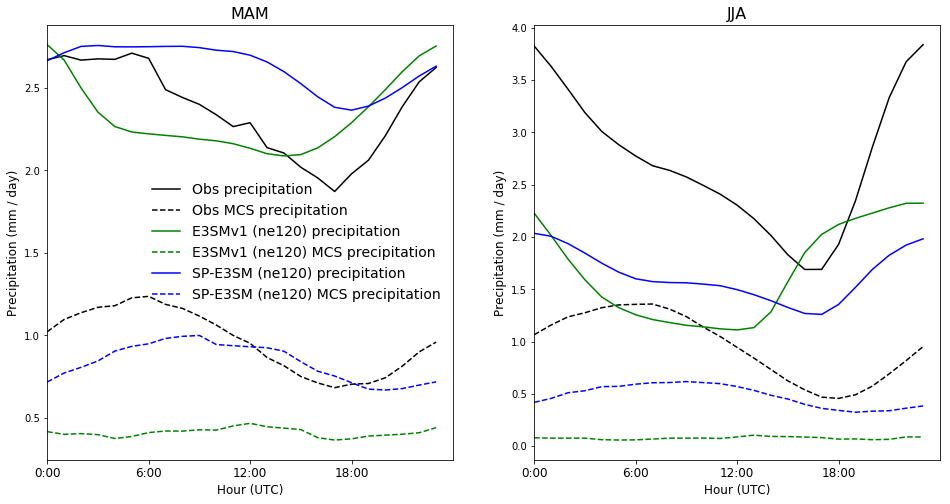

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
model_dict = {'Obs': ds_hov_obs.sel(lon=central_us180['lon']).mean(dim='lon'),
              'e3sm': ds_hov_e3sm.sel(lon=central_us['lon']).mean(dim='lon'),
              'e3sm-mmf': ds_hov_mmf.sel(lon=central_us['lon']).mean(dim='lon')}
models = ['Obs', 'e3sm', 'e3sm-mmf']
model_labels = ['Obs', 'E3SMv1 (ne120)', 'SP-E3SM (ne120)']
precip_labels = ['precipitation', 'MCS precipitation']
colors = ['black', 'green', 'blue']
styles = ['-', '--']
seasons = ['MAM', 'JJA']
plot_variables = {'Obs': ['precipitation', 'mcs_precipitation_exp'],
                  'e3sm': ['precipitation', 'mcs_precipitation'],
                  'e3sm-mmf': ['precipitation', 'mcs_precipitation']}
for ax, season in zip(axes, seasons):
    for i, key in enumerate(models):
        for jstyle, pvar in enumerate(plot_variables[key]):
            da = model_dict[key][pvar] * 24
            label = f'{model_labels[i]} {precip_labels[jstyle]}'
            p = da.sel(season=season).plot(ax=ax, x='hour', label=label, 
                                           color=colors[i], linestyle=styles[jstyle])
    ax.set_title(season, fontsize=16)
    ax.set_ylabel('Precipitation (mm / day)', fontsize=12)
    ax.set_xlabel('Hour (UTC)', fontsize=12)
    ax.set_xticks([0, 6, 12, 18])
    ax.set_xticklabels(['0:00', '6:00', '12:00', '18:00'], fontsize=12)
    ax.set_xlim([0, 24])
    # ax.set_ylim([1.0, 4.75])
# axes[0].legend(fontsize=14, frameon=False, bbox_to_anchor=(0.4, 0.6))
axes[0].legend(fontsize=14, frameon=False)
# plt.savefig('central_us_diurnal_cycle.svg', bbox_inches='tight')
# plt.savefig('central_us_diurnal_cycle.png', bbox_inches='tight', dpi=1200)

## What about the test version? -- no 10mm precip threshold
Summary of sensitivity tests: they both increase the count somewhat, but not substantially in either case. This should go in supplemental info, because it suggests results are robust.

In [12]:
%%time
ds_mmf = xr.open_mfdataset(sorted(glob('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb_no10mm/mcs_rainhov_*.nc')))
ds_e3sm = xr.open_mfdataset(sorted(glob('/global/cscratch1/sd/crjones/ECP/e3sm/statstb_no10mm/mcs_rainhov_*.nc')))
ds_hov_e3sm = ds_e3sm.groupby('time.season').apply(diurnal).load()
ds_hov_mmf = ds_mmf.groupby('time.season').apply(diurnal).load()

CPU times: user 4.52 s, sys: 661 ms, total: 5.18 s
Wall time: 6.4 s


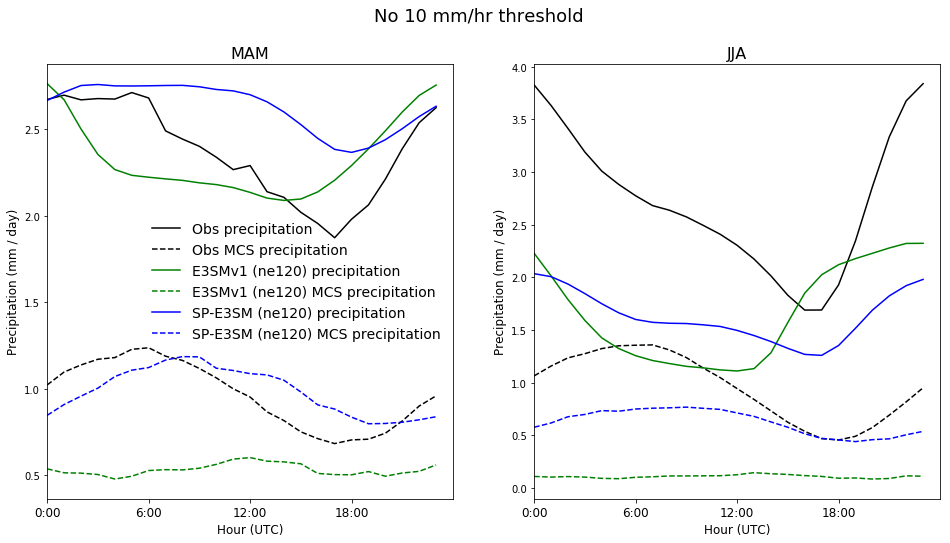

In [17]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
model_dict = {'Obs': ds_hov_obs.sel(lon=central_us180['lon']).mean(dim='lon'),
              'e3sm': ds_hov_e3sm.sel(lon=central_us['lon']).mean(dim='lon'),
              'e3sm-mmf': ds_hov_mmf.sel(lon=central_us['lon']).mean(dim='lon')}
models = ['Obs', 'e3sm', 'e3sm-mmf']
model_labels = ['Obs', 'E3SMv1 (ne120)', 'SP-E3SM (ne120)']
precip_labels = ['precipitation', 'MCS precipitation']
colors = ['black', 'green', 'blue']
styles = ['-', '--']
seasons = ['MAM', 'JJA']
plot_variables = {'Obs': ['precipitation', 'mcs_precipitation_exp'],
                  'e3sm': ['precipitation', 'mcs_precipitation'],
                  'e3sm-mmf': ['precipitation', 'mcs_precipitation']}
for ax, season in zip(axes, seasons):
    for i, key in enumerate(models):
        for jstyle, pvar in enumerate(plot_variables[key]):
            da = model_dict[key][pvar] * 24
            label = f'{model_labels[i]} {precip_labels[jstyle]}'
            p = da.sel(season=season).plot(ax=ax, x='hour', label=label, 
                                           color=colors[i], linestyle=styles[jstyle])
    ax.set_title(season, fontsize=16)
    ax.set_ylabel('Precipitation (mm / day)', fontsize=12)
    ax.set_xlabel('Hour (UTC)', fontsize=12)
    ax.set_xticks([0, 6, 12, 18])
    ax.set_xticklabels(['0:00', '6:00', '12:00', '18:00'], fontsize=12)
    ax.set_xlim([0, 24])
    # ax.set_ylim([1.0, 4.75])
fig.suptitle('No 10 mm/hr threshold', fontsize=18)
# axes[0].legend(fontsize=14, frameon=False, bbox_to_anchor=(0.4, 0.6))
axes[0].legend(fontsize=14, frameon=False)
# plt.savefig('central_us_diurnal_cycle.svg', bbox_inches='tight')
# plt.savefig('central_us_diurnal_cycle.png', bbox_inches='tight', dpi=1200)

## What about the test version? -- reduced area threshold

In [18]:
%%time
ds_mmf = xr.open_mfdataset(sorted(glob('/global/cscratch1/sd/crjones/ECP/e3sm-mmf/statstb_ccs3e4/mcs_rainhov_*.nc')))
ds_e3sm = xr.open_mfdataset(sorted(glob('/global/cscratch1/sd/crjones/ECP/e3sm/statstb_ccs3e4/mcs_rainhov_*.nc')))
ds_hov_e3sm = ds_e3sm.groupby('time.season').apply(diurnal).load()
ds_hov_mmf = ds_mmf.groupby('time.season').apply(diurnal).load()

CPU times: user 4.54 s, sys: 747 ms, total: 5.28 s
Wall time: 6.27 s


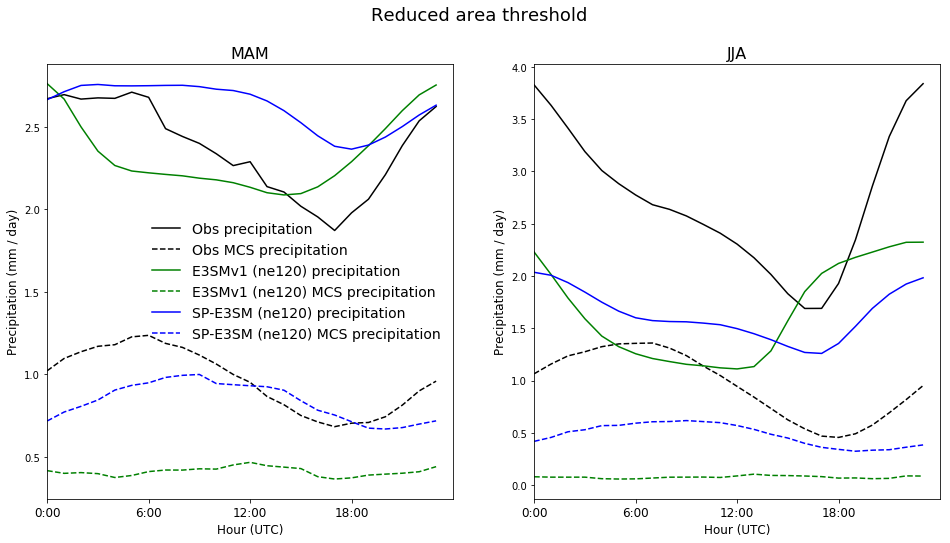

In [19]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))
model_dict = {'Obs': ds_hov_obs.sel(lon=central_us180['lon']).mean(dim='lon'),
              'e3sm': ds_hov_e3sm.sel(lon=central_us['lon']).mean(dim='lon'),
              'e3sm-mmf': ds_hov_mmf.sel(lon=central_us['lon']).mean(dim='lon')}
models = ['Obs', 'e3sm', 'e3sm-mmf']
model_labels = ['Obs', 'E3SMv1 (ne120)', 'SP-E3SM (ne120)']
precip_labels = ['precipitation', 'MCS precipitation']
colors = ['black', 'green', 'blue']
styles = ['-', '--']
seasons = ['MAM', 'JJA']
plot_variables = {'Obs': ['precipitation', 'mcs_precipitation_exp'],
                  'e3sm': ['precipitation', 'mcs_precipitation'],
                  'e3sm-mmf': ['precipitation', 'mcs_precipitation']}
for ax, season in zip(axes, seasons):
    for i, key in enumerate(models):
        for jstyle, pvar in enumerate(plot_variables[key]):
            da = model_dict[key][pvar] * 24
            label = f'{model_labels[i]} {precip_labels[jstyle]}'
            p = da.sel(season=season).plot(ax=ax, x='hour', label=label, 
                                           color=colors[i], linestyle=styles[jstyle])
    ax.set_title(season, fontsize=16)
    ax.set_ylabel('Precipitation (mm / day)', fontsize=12)
    ax.set_xlabel('Hour (UTC)', fontsize=12)
    ax.set_xticks([0, 6, 12, 18])
    ax.set_xticklabels(['0:00', '6:00', '12:00', '18:00'], fontsize=12)
    ax.set_xlim([0, 24])
    # ax.set_ylim([1.0, 4.75])
fig.suptitle('Reduced area threshold', fontsize=18)
# axes[0].legend(fontsize=14, frameon=False, bbox_to_anchor=(0.4, 0.6))
axes[0].legend(fontsize=14, frameon=False)
# plt.savefig('central_us_diurnal_cycle.svg', bbox_inches='tight')
# plt.savefig('central_us_diurnal_cycle.png', bbox_inches='tight', dpi=1200)

## bootstrap testing of obs sampling

In [8]:
def seasonal_diurnal(da):
    return da.groupby('time.season').apply(diurnal)

In [35]:
ds_obs = ds_obs.sel(lon=central_us180['lon'])

In [36]:
ds_obs_test = ds_obs.groupby('time.year').apply(seasonal_diurnal).load()
ds_obs_test

<xarray.Dataset>
Dimensions:                (hour: 24, lon: 121, season: 2, year: 13)
Coordinates:
  * lon                    (lon) float32 -110.0 -109.75 -109.5 ... -80.25 -80.0
  * hour                   (hour) int64 0 1 2 3 4 5 6 7 ... 17 18 19 20 21 22 23
  * season                 (season) object 'JJA' 'MAM'
  * year                   (year) int64 2004 2005 2006 2007 ... 2014 2015 2016
Data variables:
    precipitation          (year, season, hour, lon) float32 0.056050446 ... 0.15459411
    mcs_precipitation_ctl  (year, season, hour, lon) float32 0.0017215166 ... 0.039243527
    mcs_precipitation_exp  (year, season, hour, lon) float32 0.0 ... 0.047666717

In [10]:
# generate sample data:
import itertools
from scipy.special import binom

In [37]:
nyears = len(ds_obs_test.year)
nchoose = 7
ncombos = int(binom(nyears, nchoose))
print(ncombos)

1716


In [38]:
ds_obs_test.dims
nseason = ds_obs_test.dims['season']
nhour = ds_obs_test.dims['hour']

In [39]:
%%time
arr_precip = np.zeros((ncombos, nseason, nhour))
arr_mcs_precip = np.zeros((ncombos, nseason, nhour))
for ntrial, combo in enumerate(itertools.combinations(range(len(ds_obs_test.year)), nchoose)):
    if ntrial % 100 == 0:
        print(ntrial, combo)
    arr_precip[ntrial, :, :] = ds_obs_test['precipitation'].isel(year=list(combo)).mean(dim=['year', 'lon']).values
    arr_mcs_precip[ntrial, :, :] = ds_obs_test['mcs_precipitation_exp'].isel(year=list(combo)).mean(dim=['year', 'lon']).values

0 (0, 1, 2, 3, 4, 5, 6)
100 (0, 1, 2, 4, 5, 9, 11)
200 (0, 1, 2, 7, 8, 11, 12)
300 (0, 1, 3, 5, 10, 11, 12)
400 (0, 1, 4, 7, 10, 11, 12)
500 (0, 2, 3, 4, 7, 8, 11)
600 (0, 2, 4, 5, 6, 10, 11)
700 (0, 2, 6, 7, 9, 10, 12)
800 (0, 3, 5, 6, 9, 10, 11)
900 (0, 5, 6, 7, 8, 10, 12)
1000 (1, 2, 3, 5, 7, 9, 11)
1100 (1, 2, 4, 6, 8, 11, 12)
1200 (1, 3, 4, 5, 7, 11, 12)
1300 (1, 3, 7, 9, 10, 11, 12)
1400 (2, 3, 4, 5, 6, 11, 12)
1500 (2, 3, 6, 7, 10, 11, 12)
1600 (3, 4, 5, 6, 7, 9, 10)
1700 (4, 5, 8, 9, 10, 11, 12)
CPU times: user 3.4 s, sys: 5.12 ms, total: 3.4 s
Wall time: 3.39 s


Text(0.5, 0.98, '7 Season subsamples from 2004-2016 Obs')

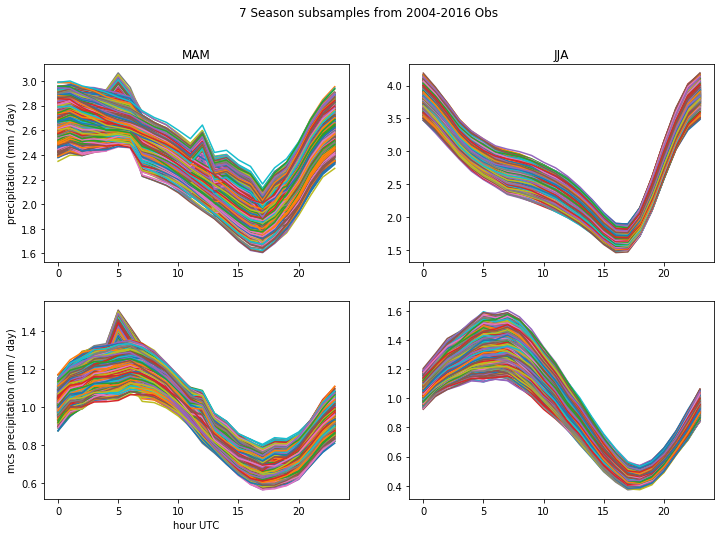

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes[0, 0].plot(ds_obs_test.hour, arr_precip[:, 1, :].transpose() * 24);
axes[0, 0].set_title('MAM')
axes[0, 0].set_ylabel('precipitation (mm / day)')

axes[0, 1].plot(ds_obs_test.hour, arr_precip[:, 0, :].transpose() * 24);
axes[0, 1].set_title('JJA')

axes[1, 0].plot(ds_obs_test.hour, arr_mcs_precip[:, 1, :].transpose() * 24);
axes[1, 0].set_ylabel('mcs precipitation (mm / day)')
axes[1, 0].set_xlabel('hour UTC')

axes[1, 1].plot(ds_obs_test.hour, arr_mcs_precip[:, 0, :].transpose() * 24);
fig.suptitle('7 Season subsamples from 2004-2016 Obs')

"\nmodels = ['Obs', 'e3sm', 'e3sm-mmf']\nmodel_labels = ['Obs', 'E3SMv1 (ne120)', 'SP-E3SM (ne120)']\nprecip_labels = ['precipitation', 'MCS precipitation']\ncolors = ['black', 'green', 'blue']\nstyle = '-'\nseasons = ['MAM', 'JJA']\nplot_variables = {'Obs': ['precipitation', 'mcs_precipitation_exp'],\n                  'e3sm': ['precipitation', 'mcs_precipitation'],\n                  'e3sm-mmf': ['precipitation', 'mcs_precipitation']}\nfor ax, season in zip(axes, seasons):\n    for i, key in enumerate(models):\n        for jstyle, pvar in enumerate(plot_variables[key]):\n            da = model_dict[key][pvar] * 24\n            label = f'{model_labels[i]} {precip_labels[jstyle]}'\n            p = da.sel(season=season).plot(ax=ax, x='hour', label=label, \n                                           color=colors[i], linestyle=styles[jstyle])\n    ax.set_title(season, fontsize=16)\n    ax.set_ylabel('Precipitation (mm / day)', fontsize=12)\n    ax.set_xlabel('Hour (UTC)', fontsize=12)\n  

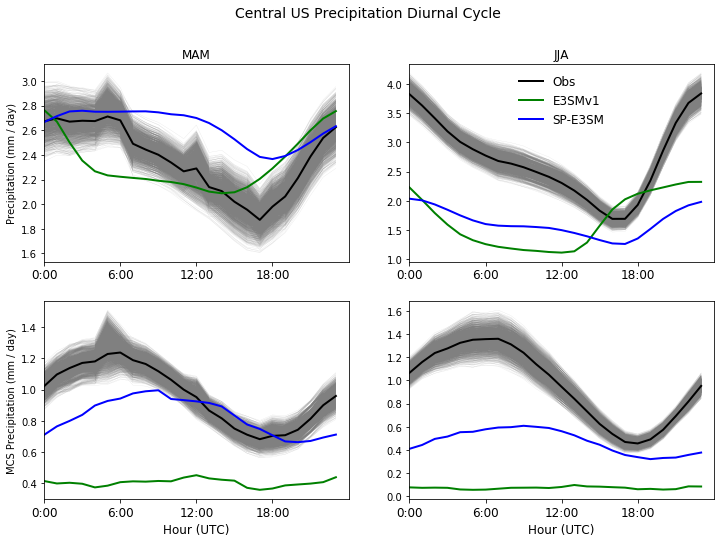

In [53]:
# add model and obs both to same plot
plot_kwargs = {'linewidth': 0.25, 'color': 'gray', 'alpha': 0.25}
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes[0, 0].plot(ds_obs_test.hour, arr_precip[:, 1, :].transpose() * 24, **plot_kwargs);
axes[0, 0].set_title('MAM')
axes[0, 0].set_ylabel('precipitation (mm / day)')

axes[0, 1].plot(ds_obs_test.hour, arr_precip[:, 0, :].transpose() * 24, **plot_kwargs);
axes[0, 1].set_title('JJA')

axes[1, 0].plot(ds_obs_test.hour, arr_mcs_precip[:, 1, :].transpose() * 24, **plot_kwargs);
axes[1, 0].set_ylabel('mcs precipitation (mm / day)')
axes[1, 0].set_xlabel('hour UTC')

axes[1, 1].plot(ds_obs_test.hour, arr_mcs_precip[:, 0, :].transpose() * 24, **plot_kwargs);
fig.suptitle('Central US Precipitation Diurnal Cycle', fontsize=14)

model_dict = {'Obs': ds_hov_obs.sel(lon=central_us180['lon']).mean(dim='lon'),
              'e3sm': ds_hov_e3sm.sel(lon=central_us['lon']).mean(dim='lon'),
              'e3sm-mmf': ds_hov_mmf.sel(lon=central_us['lon']).mean(dim='lon')}
(model_dict['Obs']['precipitation'].sel(season='MAM') * 24).plot(ax=axes[0, 0], x='hour', color='k', linewidth=2)
(model_dict['e3sm']['precipitation'].sel(season='MAM') * 24).plot(ax=axes[0, 0], x='hour', color='g', linewidth=2)
(model_dict['e3sm-mmf']['precipitation'].sel(season='MAM') * 24).plot(ax=axes[0, 0], x='hour', color='b', linewidth=2)

p1 = (model_dict['Obs']['precipitation'].sel(season='JJA') * 24).plot(ax=axes[0, 1], x='hour', color='k', linewidth=2, label='Obs')
p2 = (model_dict['e3sm']['precipitation'].sel(season='JJA') * 24).plot(ax=axes[0, 1], x='hour', color='g', linewidth=2, label='E3SMv1')
p3 = (model_dict['e3sm-mmf']['precipitation'].sel(season='JJA') * 24).plot(ax=axes[0, 1], x='hour', color='b', linewidth=2, label='SP-E3SM')

(model_dict['Obs']['mcs_precipitation_exp'].sel(season='MAM') * 24).plot(ax=axes[1, 0], x='hour', color='k', linewidth=2)
(model_dict['e3sm']['mcs_precipitation'].sel(season='MAM') * 24).plot(ax=axes[1, 0], x='hour', color='g', linewidth=2)
(model_dict['e3sm-mmf']['mcs_precipitation'].sel(season='MAM') * 24).plot(ax=axes[1, 0], x='hour', color='b', linewidth=2)

(model_dict['Obs']['mcs_precipitation_exp'].sel(season='JJA') * 24).plot(ax=axes[1, 1], x='hour', color='k', linewidth=2)
(model_dict['e3sm']['mcs_precipitation'].sel(season='JJA') * 24).plot(ax=axes[1, 1], x='hour', color='g', linewidth=2)
(model_dict['e3sm-mmf']['mcs_precipitation'].sel(season='JJA') * 24).plot(ax=axes[1, 1], x='hour', color='b', linewidth=2)

for ax in (axes[1, 0], axes[1, 1]):
    ax.set_xlabel('Hour (UTC)', fontsize=12)
    ax.set_xticks([0, 6, 12, 18])
    ax.set_xticklabels(['0:00', '6:00', '12:00', '18:00'], fontsize=12)
    ax.set_xlim([0, 24])
    ax.set_title('')
    ax.set_ylabel('')
for ax, seas in zip(axes[0, :], ['MAM', 'JJA']):
    ax.set_xticks([0, 6, 12, 18])
    ax.set_xticklabels(['0:00', '6:00', '12:00', '18:00'], fontsize=12)
    ax.set_xlim([0, 24])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(seas, fontsize=12)

axes[0, 0].set_ylabel('Precipitation (mm / day)')
axes[1, 0].set_ylabel('MCS Precipitation (mm / day)')
axes[0, 1].legend(frameon=False, fontsize=12)

In [54]:
# Three year subsamples
nyears = len(ds_obs_test.year)
nchoose = 3
ncombos = int(binom(nyears, nchoose))
print(ncombos)

286


In [55]:
%%time
arr_precip = np.zeros((ncombos, nseason, nhour))
arr_mcs_precip = np.zeros((ncombos, nseason, nhour))
for ntrial, combo in enumerate(itertools.combinations(range(len(ds_obs_test.year)), nchoose)):
    if ntrial % 100 == 0:
        print(ntrial, combo)
    arr_precip[ntrial, :, :] = ds_obs_test['precipitation'].isel(year=list(combo)).mean(dim=['year', 'lon']).values
    arr_mcs_precip[ntrial, :, :] = ds_obs_test['mcs_precipitation_exp'].isel(year=list(combo)).mean(dim=['year', 'lon']).values

0 (0, 1, 2)
100 (1, 6, 7)
200 (3, 10, 12)
CPU times: user 542 ms, sys: 0 ns, total: 542 ms
Wall time: 549 ms


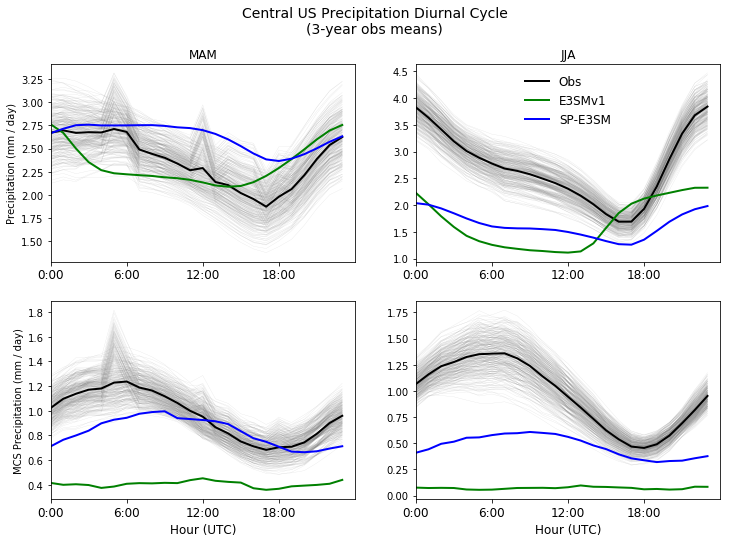

In [59]:
# add model and obs both to same plot
plot_kwargs = {'linewidth': 0.25, 'color': 'gray', 'alpha': 0.25}
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8))
axes[0, 0].plot(ds_obs_test.hour, arr_precip[:, 1, :].transpose() * 24, **plot_kwargs);
axes[0, 0].set_title('MAM')
axes[0, 0].set_ylabel('precipitation (mm / day)')

axes[0, 1].plot(ds_obs_test.hour, arr_precip[:, 0, :].transpose() * 24, **plot_kwargs);
axes[0, 1].set_title('JJA')

axes[1, 0].plot(ds_obs_test.hour, arr_mcs_precip[:, 1, :].transpose() * 24, **plot_kwargs);
axes[1, 0].set_ylabel('mcs precipitation (mm / day)')
axes[1, 0].set_xlabel('hour UTC')

axes[1, 1].plot(ds_obs_test.hour, arr_mcs_precip[:, 0, :].transpose() * 24, **plot_kwargs);
fig.suptitle('Central US Precipitation Diurnal Cycle\n(3-year obs means)', fontsize=14)

model_dict = {'Obs': ds_hov_obs.sel(lon=central_us180['lon']).mean(dim='lon'),
              'e3sm': ds_hov_e3sm.sel(lon=central_us['lon']).mean(dim='lon'),
              'e3sm-mmf': ds_hov_mmf.sel(lon=central_us['lon']).mean(dim='lon')}
(model_dict['Obs']['precipitation'].sel(season='MAM') * 24).plot(ax=axes[0, 0], x='hour', color='k', linewidth=2)
(model_dict['e3sm']['precipitation'].sel(season='MAM') * 24).plot(ax=axes[0, 0], x='hour', color='g', linewidth=2)
(model_dict['e3sm-mmf']['precipitation'].sel(season='MAM') * 24).plot(ax=axes[0, 0], x='hour', color='b', linewidth=2)

p1 = (model_dict['Obs']['precipitation'].sel(season='JJA') * 24).plot(ax=axes[0, 1], x='hour', color='k', linewidth=2, label='Obs')
p2 = (model_dict['e3sm']['precipitation'].sel(season='JJA') * 24).plot(ax=axes[0, 1], x='hour', color='g', linewidth=2, label='E3SMv1')
p3 = (model_dict['e3sm-mmf']['precipitation'].sel(season='JJA') * 24).plot(ax=axes[0, 1], x='hour', color='b', linewidth=2, label='SP-E3SM')

(model_dict['Obs']['mcs_precipitation_exp'].sel(season='MAM') * 24).plot(ax=axes[1, 0], x='hour', color='k', linewidth=2)
(model_dict['e3sm']['mcs_precipitation'].sel(season='MAM') * 24).plot(ax=axes[1, 0], x='hour', color='g', linewidth=2)
(model_dict['e3sm-mmf']['mcs_precipitation'].sel(season='MAM') * 24).plot(ax=axes[1, 0], x='hour', color='b', linewidth=2)

(model_dict['Obs']['mcs_precipitation_exp'].sel(season='JJA') * 24).plot(ax=axes[1, 1], x='hour', color='k', linewidth=2)
(model_dict['e3sm']['mcs_precipitation'].sel(season='JJA') * 24).plot(ax=axes[1, 1], x='hour', color='g', linewidth=2)
(model_dict['e3sm-mmf']['mcs_precipitation'].sel(season='JJA') * 24).plot(ax=axes[1, 1], x='hour', color='b', linewidth=2)

for ax in (axes[1, 0], axes[1, 1]):
    ax.set_xlabel('Hour (UTC)', fontsize=12)
    ax.set_xticks([0, 6, 12, 18])
    ax.set_xticklabels(['0:00', '6:00', '12:00', '18:00'], fontsize=12)
    ax.set_xlim([0, 24])
    ax.set_title('')
    ax.set_ylabel('')
for ax, seas in zip(axes[0, :], ['MAM', 'JJA']):
    ax.set_xticks([0, 6, 12, 18])
    ax.set_xticklabels(['0:00', '6:00', '12:00', '18:00'], fontsize=12)
    ax.set_xlim([0, 24])
    ax.set_xlabel('')
    ax.set_ylabel('')
    ax.set_title(seas, fontsize=12)

axes[0, 0].set_ylabel('Precipitation (mm / day)')
axes[1, 0].set_ylabel('MCS Precipitation (mm / day)')
axes[0, 1].legend(frameon=False, fontsize=12)

# Large-scale features (LHFLX, SHFLX, integrated water)

In [2]:
def preprocess_climo(ds):
    seasons = ['DJF', 'MAM', 'JJA', 'SON']
    fname = ds.input_file
    this_season = [s for s in seasons if s in fname]
    new_ds = ds.groupby('time.season').mean(dim='time')
    new_ds['season'].values[0] = this_season[0]
    return(new_ds)

In [32]:
# prepare figure canvas:
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

def markup_facetgrid(p):
    for ax in p.axes.flat:
        ax.add_feature(states_provinces, edgecolor='black', alpha=0.5, zorder=0)
        ax.coastlines()
        gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
        gl.xlabels_top = False
        gl.ylabels_right = False
        gl.xformatter = LONGITUDE_FORMATTER
        gl.yformatter = LATITUDE_FORMATTER
        ax.add_feature(cfeature.OCEAN)
        ax.add_feature(cfeature.BORDERS, linestyle='-', alpha=1)
        ax.add_feature(cfeature.LAND)

In [4]:
ds = xr.open_mfdataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science/monthly_hist/clim_rgr/0002-0007/earlyscience.FC5AV1C-H01A.ne120.sp1_64x1_1000m_[DMJS]??_climo.nc',
                       preprocess=preprocess_climo)

<xarray.Dataset>
Dimensions:          (ilev: 73, lat: 180, lev: 72, lon: 360, nbnd: 2, season: 4)
Coordinates:
  * lat              (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon              (lon) float64 0.5 1.5 2.5 3.5 ... 356.5 357.5 358.5 359.5
  * ilev             (ilev) float64 0.1 0.1477 0.218 ... 990.5 997.0 1e+03
  * lev              (lev) float64 0.1238 0.1828 0.2699 ... 986.2 993.8 998.5
  * season           (season) object 'DJF' 'JJA' 'MAM' 'SON'
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds         (season, lat, nbnd) float64 dask.array<shape=(4, 180, 2), chunksize=(1, 180, 2)>
    lon_bnds         (season, lon, nbnd) float64 dask.array<shape=(4, 360, 2), chunksize=(1, 360, 2)>
    gw               (season, lat) float64 dask.array<shape=(4, 180), chunksize=(1, 180)>
    area             (season, lat, lon) float64 dask.array<shape=(4, 180, 360), chunksize=(1, 180, 360)>
    AEROD_v          (season, lat, lon) float32 dask.array<shape=(

In [5]:
ds0 = xr.open_mfdataset('/global/project/projectdirs/m3312/crjones/e3sm/early_science_e3sm/clim_rgr/0001-0003/earlyscience.FC5AV1C-H01A.ne120.E3SM.20190329_[DMJS]??_climo.nc',
                        preprocess=preprocess_climo)
ds0.dims

Frozen(SortedKeysDict({'lat': 180, 'lon': 360, 'ilev': 73, 'lev': 72, 'season': 4, 'nbnd': 2}))

In [7]:
variables = ['LHFLX', 'SHFLX', 'TMQ']

In [8]:
ds_models = xr.concat([ds[variables], ds0[variables]], dim=pd.Index(['SP-E3SM', 'E3SM'], name='model'))

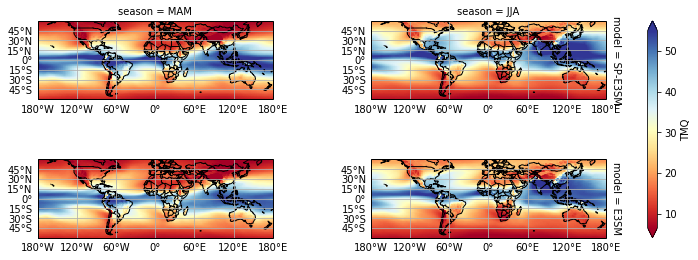

In [33]:
p = ds_models['TMQ'].sel(season=['MAM','JJA'], lat=slice(-60, 60)).plot(row='model', col='season', robust=True,
                                                                        subplot_kws={'projection': ccrs.PlateCarree()},
                                                                        transform=ccrs.PlateCarree(),
                                                                        figsize=(12, 4),
                                                                        cmap=plt.cm.RdYlBu,
                                                                       )
markup_facetgrid(p)

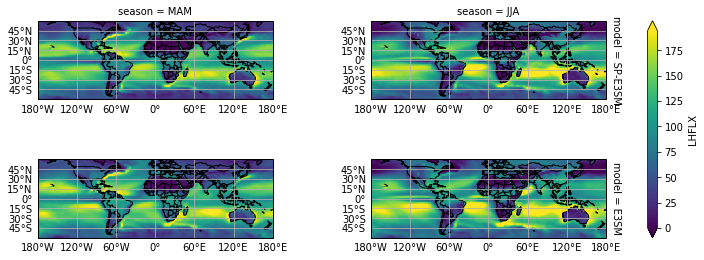

In [30]:
p = ds_models['LHFLX'].sel(season=['MAM','JJA'], lat=slice(-60, 60)).plot(row='model', col='season', robust=True,
                                                                        subplot_kws={'projection': ccrs.PlateCarree()},
                                                                        transform=ccrs.PlateCarree(),
                                                                        figsize=(12, 4),
                                                                        vmin=0,
                                                                       )
markup_facetgrid(p)

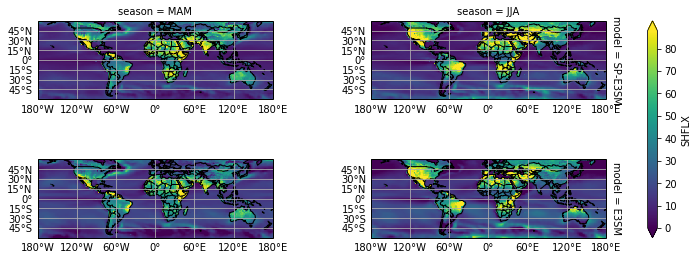

In [31]:
p = ds_models['SHFLX'].sel(season=['MAM','JJA'], lat=slice(-60, 60)).plot(row='model', col='season', robust=True,
                                                                          subplot_kws={'projection': ccrs.PlateCarree()},
                                                                          transform=ccrs.PlateCarree(),
                                                                          figsize=(12, 4),
                                                                          vmin=0,
                                                                         )
markup_facetgrid(p)

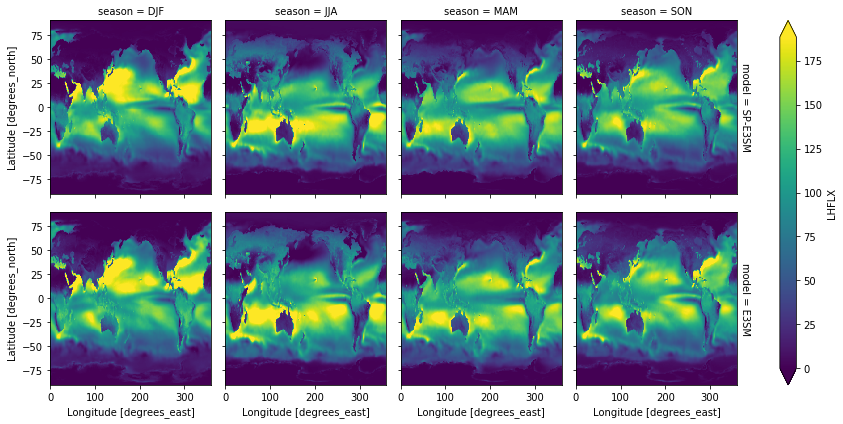

In [13]:
ds_models['LHFLX'].plot(row='model', col='season', robust=True, vmin=0)

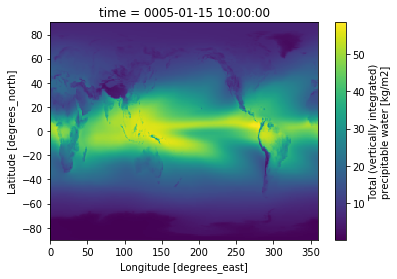

In [62]:
ds.TMQ.plot()

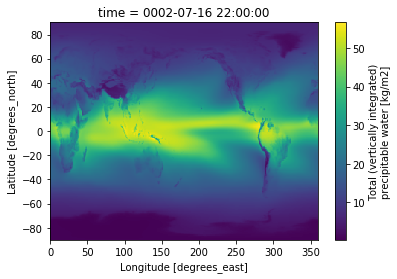

In [64]:
ds0['TMQ'].plot()

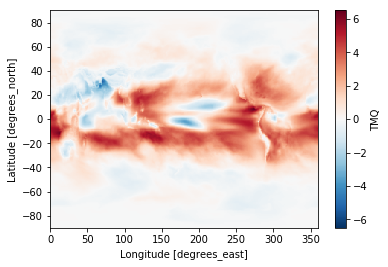

In [66]:
(ds['TMQ'].squeeze() - ds0['TMQ'].squeeze()).plot()